In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier # Added StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB # Keep GaussianNB for scaled continuous features
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score # Added roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel # For loading the selector
import warnings
warnings.filterwarnings('ignore')

/var/folders/fl/_zgwb4_x0653c4k5cg1l1mxr0000gn/T/ipykernel_40652/1790657558.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [15]:
# Directory where engineered features from official splits are saved
features_dir = "hyperpartisan_features_official" 
# Directory to save baseline models trained on official splits
models_dir = "hyperpartisan_models_official" 
official_data_dir = "hyperpartisan_data_official" 
os.makedirs(models_dir, exist_ok=True)

# --- Load NLTK (ensure vader lexicon is available for feature importance check later if needed)
import nltk
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon', quiet=True)

# Set style for visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

SEED = 42 # Define seed for reproducibility

In [16]:
# --- Load Data ---
print("--- Loading Features from Official Splits ---")
X_train_path = os.path.join(features_dir, 'X_train_scaled.csv')
X_test_path = os.path.join(features_dir, 'X_test_scaled.csv')
y_train_path = os.path.join(features_dir, 'y_train.csv')
y_test_path = os.path.join(features_dir, 'y_test.csv')

if not all(os.path.exists(p) for p in [X_train_path, X_test_path, y_train_path, y_test_path]):
     raise FileNotFoundError(f"Ensure scaled feature files exist in '{features_dir}'. Run feature engineering script first.")

X_train_scaled = pd.read_csv(X_train_path)
X_test_scaled = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)['hyperpartisan']
y_test = pd.read_csv(y_test_path)['hyperpartisan'] # This is y_test_official

test_csv_path = os.path.join(official_data_dir, "official_test_data.csv") 

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")
print(f"Class distribution in training set (% Hyperpartisan): {y_train.mean():.2f}")
print(f"Class distribution in test set (% Hyperpartisan): {y_test.mean():.2f}")

--- Loading Features from Official Splits ---
Training features shape: (645, 1137)
Test features shape: (628, 1137)
Class distribution in training set (% Hyperpartisan): 0.37
Class distribution in test set (% Hyperpartisan): 0.50


In [4]:
# --- Load Feature Selector ---
# Assumes tree-based selector was saved. Change filename if using 'l1'.
selector_path = os.path.join(features_dir, 'feature_selector_tree.pkl') 
selected_feature_names = None # Initialize

print(f"Attempting to load feature selector from: {selector_path}")

Attempting to load feature selector from: hyperpartisan_features_official/feature_selector_tree.pkl


In [5]:

try:
    with open(selector_path, 'rb') as f:
        selector = pickle.load(f)
    print("Loaded feature selector.")
    
    # Get the boolean mask from the fitted selector
    selected_features_mask = selector.get_support()
    
    # Ensure mask length matches the number of columns in the loaded data
    if len(selected_features_mask) == X_train_scaled.shape[1]:
        selected_feature_names = X_train_scaled.columns[selected_features_mask].tolist()
        
        # Apply the selection using the column names derived from the mask
        X_train_selected = X_train_scaled[selected_feature_names]
        X_test_selected = X_test_scaled[selected_feature_names]
        print(f"Applied feature selection. Using {len(selected_feature_names)} features.")
    else:
         print(f"Warning: Mismatch between selector mask length ({len(selected_features_mask)}) and current data columns ({X_train_scaled.shape[1]}).")
         print("Using all features as a fallback.")
         X_train_selected = X_train_scaled
         X_test_selected = X_test_scaled
         selected_feature_names = X_train_scaled.columns.tolist()

except FileNotFoundError:
    print(f"Feature selector file not found at {selector_path}. Using all features.")
    X_train_selected = X_train_scaled
    X_test_selected = X_test_scaled
    selected_feature_names = X_train_scaled.columns.tolist()
except Exception as e:
     print(f"Error loading or applying feature selector: {e}. Using all features.")
     X_train_selected = X_train_scaled
     X_test_selected = X_test_scaled
     selected_feature_names = X_train_scaled.columns.tolist()


Feature selector file not found at hyperpartisan_features_official/feature_selector_tree.pkl. Using all features.


In [6]:
# Display shape after selection
print(f"Training features shape after selection: {X_train_selected.shape}")
print(f"Test features shape after selection: {X_test_selected.shape}")

Training features shape after selection: (645, 1137)
Test features shape after selection: (628, 1137)


In [7]:
# --- Helper function for Training and Evaluation ---
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, models_dir):
    """Train and evaluate a model on the official splits, saving the results"""
    print(f"\n--- Training and Evaluating {model_name} ---")
    
    start_time = time.time()
    # Train the model
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f}s")
    
    # Make predictions on the OFFICIAL test set
    start_time = time.time()
    y_pred = model.predict(X_test)
    # Get probabilities if possible (for AUC)
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        except Exception as e:
            print(f"Could not get probabilities for {model_name}: {e}")
            if hasattr(model, "decision_function"):
                try:
                    y_pred_proba = model.decision_function(X_test)
                    print("Using decision_function for ROC curve.")
                except Exception:
                     print("Could not get decision_function either.")
            else:
                 print("No probability or decision function available.")

    predict_time = time.time() - start_time
    print(f"Prediction completed in {predict_time:.2f}s")
    
    # --- Evaluation ---
    print(f"\n{model_name} Performance on Official Test Set:")
    
    # Classification Report
    print("Classification Report:")
    # Use zero_division=0 to avoid warnings for metrics that might be zero
    print(classification_report(y_test, y_pred, zero_division=0))
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Cross-validation score ON TRAINING DATA
    print("\nPerforming 5-fold CV on Training Data (for stability check)...")
    try:
        # Use weighted F1 for CV scoring as test set evaluation uses it
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
        print(f"5-fold CV Weighted F1 Score (Train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        cv_mean_f1 = cv_scores.mean()
    except Exception as e:
        print(f"Could not perform cross-validation for {model_name}: {e}")
        cv_mean_f1 = np.nan 

    # --- Save Model ---
    model_filename = f'{model_name.lower().replace(" ", "_")}.pkl'
    model_path = os.path.join(models_dir, model_filename)
    try:
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Error saving model {model_name}: {e}")

    # --- Create Evaluation Visualizations ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{model_name} - Evaluation on Official Test Set', fontsize=16)
    
    # Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Not Hyp.', 'Hyperpart.'],
                yticklabels=['Not Hyp.', 'Hyperpart.'])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # ROC Curve
    roc_auc = np.nan # Default to NaN
    if y_pred_proba is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
            axes[1].plot([0, 1], [0, 1], 'k--', label='Chance') # Add chance line
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title('ROC Curve')
            axes[1].legend(loc='lower right')
        except ValueError as e:
            print(f"Could not plot ROC curve for {model_name}: {e}")
            axes[1].text(0.5, 0.5, 'ROC Curve N/A', ha='center', va='center')
            axes[1].set_title('ROC Curve (N/A)')
    else:
        axes[1].text(0.5, 0.5, 'ROC Curve N/A\n(No probabilities)', ha='center', va='center')
        axes[1].set_title('ROC Curve (N/A)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plot_filename = f'{model_name.lower().replace(" ", "_")}_official_eval.png'
    plot_path = os.path.join(models_dir, plot_filename)
    try:
        plt.savefig(plot_path)
        print(f"Evaluation plot saved to {plot_path}")
    except Exception as e:
        print(f"Error saving plot for {model_name}: {e}")
    plt.close(fig) # Close the figure 
    
    # Return calculated metrics for comparison table
    metrics_dict = {
        'Accuracy': report_dict['accuracy'],
        'AUC': roc_auc if roc_auc is not None else np.nan, 
        'Precision (Hyp)': report_dict['1']['precision'], # Class 1 (True)
        'Recall (Hyp)': report_dict['1']['recall'],
        'F1 (Hyp)': report_dict['1']['f1-score'],
        'F1 (Weighted)': report_dict['weighted avg']['f1-score'],
        'CV F1 (Train)': cv_mean_f1
    }
    return model, metrics_dict


In [8]:
# --- Define and Run Baseline Models ---
models_to_run = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=SEED, class_weight='balanced'), 
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced', n_jobs=-1), # Use n_jobs for RF
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=SEED), 
    'SVM': SVC(probability=True, random_state=SEED, class_weight='balanced'), 
    'Gaussian Naive Bayes': GaussianNB() 
}

# Store results
baseline_results = {}

print("\n--- Training Baseline Models ---")
for name, model in models_to_run.items():
    # Pass the correct output directory
    _, metrics = train_and_evaluate_model(
        model, X_train_selected, y_train, X_test_selected, y_test, name, models_dir
    )
    baseline_results[name] = metrics



--- Training Baseline Models ---

--- Training and Evaluating Logistic Regression ---
Training completed in 0.07s
Prediction completed in 0.02s

Logistic Regression Performance on Official Test Set:
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       314
           1       0.75      0.68      0.71       314

    accuracy                           0.73       628
   macro avg       0.73      0.73      0.73       628
weighted avg       0.73      0.73      0.73       628

Confusion Matrix:
[[244  70]
 [102 212]]

Performing 5-fold CV on Training Data (for stability check)...
5-fold CV Weighted F1 Score (Train): 0.7134 ± 0.0197
Model saved to hyperpartisan_models_official/logistic_regression.pkl
Evaluation plot saved to hyperpartisan_models_official/logistic_regression_official_eval.png

--- Training and Evaluating Random Forest ---
Training completed in 0.10s
Prediction completed in 0.04s

Random Forest Performanc

In [9]:
# --- Stacking Classifier ---
print("\n--- Training Stacking Classifier ---")
# Define base estimators (use default parameters for stacking base)
estimators = [
    # Using fewer estimators in base models can speed up stacking
    ('rf', RandomForestClassifier(n_estimators=50, random_state=SEED, class_weight='balanced', n_jobs=-1)), 
    ('lr', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('gnb', GaussianNB()),
    ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=SEED)) # Smaller GBT for stacking
    #('svm', SVC(probability=True, random_state=SEED, class_weight='balanced', C=1)), # SVM can be slow
]

# Meta-learner
final_logistic = LogisticRegression(random_state=SEED)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_logistic,
    cv=5, # Internal CV for generating meta-features
    stack_method='predict_proba', # Use probabilities as meta-features
    n_jobs=-1, # Use all available CPU cores
    passthrough=False # Only use predictions from base models
)

stack_name = "Stacking Ensemble"
_, stack_metrics = train_and_evaluate_model(
    stack_model, X_train_selected, y_train, X_test_selected, y_test, stack_name, models_dir
)
baseline_results[stack_name] = stack_metrics



--- Training Stacking Classifier ---

--- Training and Evaluating Stacking Ensemble ---
Training completed in 2.04s
Prediction completed in 0.13s

Stacking Ensemble Performance on Official Test Set:
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       314
           1       0.82      0.65      0.72       314

    accuracy                           0.75       628
   macro avg       0.76      0.75      0.75       628
weighted avg       0.76      0.75      0.75       628

Confusion Matrix:
[[268  46]
 [110 204]]

Performing 5-fold CV on Training Data (for stability check)...
5-fold CV Weighted F1 Score (Train): 0.7409 ± 0.0248
Model saved to hyperpartisan_models_official/stacking_ensemble.pkl
Evaluation plot saved to hyperpartisan_models_official/stacking_ensemble_official_eval.png



--- Baseline Model Performance Summary (Official Test Set) ---
                      Accuracy       AUC  F1 (Weighted)  F1 (Hyp)  \
SVM                   0.757962  0.832823       0.756539  0.737931   
Stacking Ensemble     0.751592  0.832549       0.748985  0.723404   
Logistic Regression   0.726115  0.789038       0.725402  0.711409   
Gaussian Naive Bayes  0.681529  0.720242       0.680982  0.694190   
Gradient Boosting     0.711783  0.800347       0.706908  0.669104   
Random Forest         0.718153  0.819465       0.710047  0.661568   

                      Precision (Hyp)  Recall (Hyp)  CV F1 (Train)  
SVM                          0.804511      0.681529       0.748451  
Stacking Ensemble            0.816000      0.649682       0.740923  
Logistic Regression          0.751773      0.675159       0.713417  
Gaussian Naive Bayes         0.667647      0.722930       0.639315  
Gradient Boosting            0.785408      0.582803       0.730620  
Random Forest                0.827751 

<Figure size 1000x600 with 0 Axes>

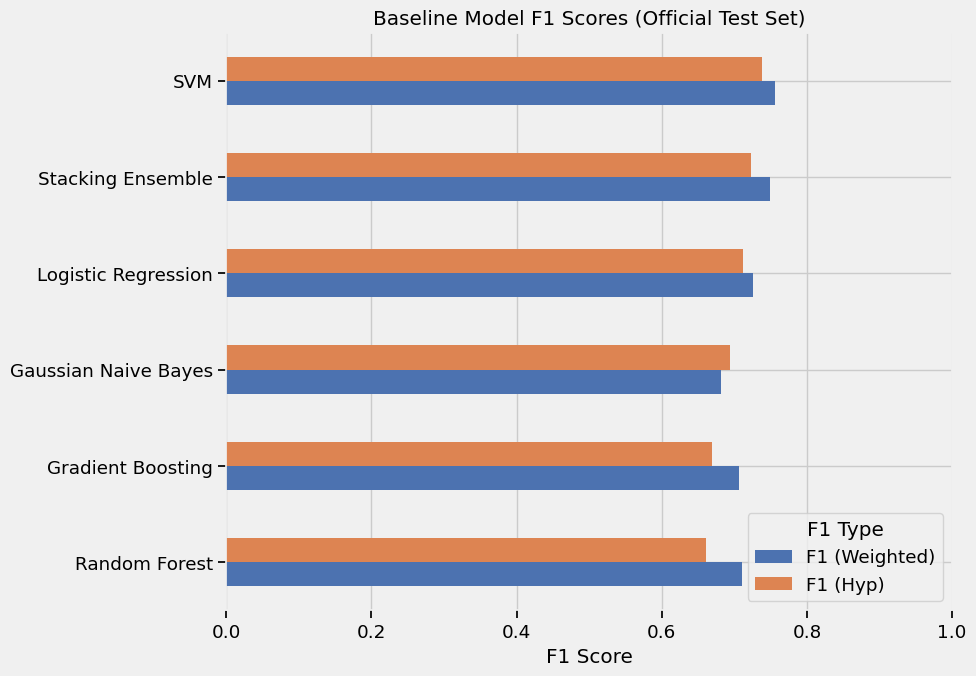


Best initial baseline model based on F1 (Hyp): SVM
Proceeding with hyperparameter tuning for this model...

Tuning hyperparameters for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale'}
Best CV F1 score (for positive class): 0.6503

Training final tuned model on full training data...


In [12]:
# --- Compare Model Performances ---
print("\n--- Baseline Model Performance Summary (Official Test Set) ---")
scores_df = pd.DataFrame(baseline_results).T # Transpose for models as rows
# Reorder columns for clarity
scores_df = scores_df[['Accuracy', 'AUC', 'F1 (Weighted)', 'F1 (Hyp)', 'Precision (Hyp)', 'Recall (Hyp)', 'CV F1 (Train)']]
scores_df = scores_df.sort_values(by='F1 (Hyp)', ascending=False) # Sort by F1 score for hyperpartisan class
print(scores_df) 

# Visualize F1 scores
plt.figure(figsize=(10, 6))
scores_df[['F1 (Weighted)', 'F1 (Hyp)']].sort_values(by='F1 (Hyp)').plot(kind='barh', figsize=(10, 7))
plt.title('Baseline Model F1 Scores (Official Test Set)')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.legend(title="F1 Type", loc='lower right')
plt.tight_layout()
plot_path = os.path.join(models_dir, 'baseline_model_comparison_f1.png')
try:
    plt.savefig(plot_path)
    print(f"\nComparison plot saved to {plot_path}")
except Exception as e:
    print(f"Error saving comparison plot: {e}")
plt.show()


# --- Hyperparameter Tuning ---
skip_tuning = False # Flag to skip if best model is GNB or Stacking

# Identify the best model based on F1 score for the hyperpartisan class
if not scores_df.empty:
    best_model_name = scores_df['F1 (Hyp)'].idxmax() 
    print(f"\nBest initial baseline model based on F1 (Hyp): {best_model_name}")
    print("Proceeding with hyperparameter tuning for this model...")
else:
    print("Error: scores_df is empty, cannot determine best model. Skipping tuning.")
    best_model_name = None
    skip_tuning = True

param_grid = None
base_model = None

if best_model_name == 'Logistic Regression':
    param_grid = {'C': [0.05, 0.1, 0.5, 1, 5, 10], 'class_weight': ['balanced']} # Focused grid
    base_model = LogisticRegression(max_iter=2000, random_state=SEED, solver='liblinear', class_weight='balanced') 
elif best_model_name == 'Random Forest':
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 3], 'class_weight': ['balanced']}
    base_model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
elif best_model_name == 'Gradient Boosting':
    param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [3, 5]} # Slightly adjusted grid
    base_model = GradientBoostingClassifier(random_state=SEED)
elif best_model_name == 'SVM':
    param_grid = {'C': [0.5, 1, 5, 10], 'gamma': [0.01, 0.1, 'scale'], 'class_weight': ['balanced']} # RBF kernel assumed
    base_model = SVC(probability=True, random_state=SEED, class_weight='balanced')
elif best_model_name == 'Gaussian Naive Bayes':
     print("Skipping tuning for GaussianNB (few parameters).")
     tuned_model = models_to_run.get('Gaussian Naive Bayes') # Get the already trained model
     best_params = {} 
     skip_tuning = True
elif best_model_name == 'Stacking Ensemble':
     print("Skipping tuning for Stacking Ensemble (complex).")
     # Need to re-retrieve the fitted stacking model from the results dict
     # This assumes 'results' dictionary is still populated from the previous cell
     tuned_model = results.get(stack_name, {}).get('model') 
     if tuned_model is None:
         print("Error: Could not retrieve fitted Stacking model. Cannot proceed.")
         skip_tuning = True
     best_params = {} 
     skip_tuning = True
else:
     print(f"Best model '{best_model_name}' not recognized or no results available. Skipping tuning.")
     skip_tuning = True
     tuned_model = None # Ensure tuned_model is defined

# --- Perform Grid Search if applicable ---
if not skip_tuning and base_model is not None and param_grid is not None:
    print(f"\nTuning hyperparameters for {best_model_name}...")
    # Optimize for F1 score of the positive class (hyperpartisan=1)
    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1 
    )
    grid_search.fit(X_train_selected, y_train) # Tune on the training data

    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")
    print(f"Best CV F1 score (for positive class): {grid_search.best_score_:.4f}")

    # Train final tuned model with best parameters on the full training set
    tuned_model = grid_search.best_estimator_
    print("\nTraining final tuned model on full training data...")
    tuned_model.fit(X_train_selected, y_train) 
elif not skip_tuning and tuned_model is None:
    print("Error: Could not proceed with evaluation as tuned_model is not defined.")
    # Handle error, maybe exit or default to a model
else: # Case where tuning was skipped (GNB or Stacking or error)
    print(f"Using default {best_model_name} model (tuning skipped).")
    # Ensure tuned_model is the one trained earlier if tuning was skipped
    if best_model_name in results:
        tuned_model = results[best_model_name]['model']
    else:
        print(f"Error: Could not find model '{best_model_name}' in results. Cannot proceed.")
        tuned_model = None # Or raise an error



In [13]:
# --- Evaluate final tuned (or best default) model ---
if tuned_model is not None:
    print("\n--- Final Baseline Model Performance (Official Test Set) ---")
    model_eval_name = f"Final Tuned {best_model_name}" if not skip_tuning else f"Final {best_model_name}"

    y_pred_final = tuned_model.predict(X_test_selected)
    y_pred_proba_final = None
    if hasattr(tuned_model, "predict_proba"):
        try:
            y_pred_proba_final = tuned_model.predict_proba(X_test_selected)[:, 1]
        except Exception:
            if hasattr(tuned_model, "decision_function"):
                 try:
                    y_pred_proba_final = tuned_model.decision_function(X_test_selected)
                    print("Using decision function for AUC calculation.")
                 except Exception: pass # Ignore if decision_function also fails
    
    print(f"Classification Report for {model_eval_name}:")
    print(classification_report(y_test, y_pred_final, zero_division=0))
    final_report_dict = classification_report(y_test, y_pred_final, output_dict=True, zero_division=0)

    # Calculate final metrics
    final_accuracy = final_report_dict['accuracy']
    final_precision = final_report_dict['1']['precision']
    final_recall = final_report_dict['1']['recall']
    final_f1 = final_report_dict['1']['f1-score']
    final_f1_weighted = final_report_dict['weighted avg']['f1-score']
    final_auc = roc_auc_score(y_test, y_pred_proba_final) if y_pred_proba_final is not None else np.nan

    print("\nSummary Metrics for Final Baseline Model:")
    print(f"Model: {model_eval_name}")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"AUC: {final_auc:.4f}")
    print(f"Precision (Hyp): {final_precision:.4f}")
    print(f"Recall (Hyp): {final_recall:.4f}")
    print(f"F1 Score (Hyp): {final_f1:.4f}")
    print(f"F1 Score (Weighted): {final_f1_weighted:.4f}")

    # Save the final selected baseline model
    final_model_filename = 'final_baseline_model.pkl'
    final_model_path = os.path.join(models_dir, final_model_filename)
    try:
        with open(final_model_path, 'wb') as f:
            pickle.dump(tuned_model, f)
        print(f"\nFinal baseline model saved to {final_model_path}")
    except Exception as e:
        print(f"Error saving final baseline model: {e}")
else:
     print("Skipping final baseline model evaluation as model could not be determined.")


--- Final Baseline Model Performance (Official Test Set) ---
Classification Report for Final Tuned SVM:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       314
           1       0.73      0.77      0.75       314

    accuracy                           0.74       628
   macro avg       0.74      0.74      0.74       628
weighted avg       0.74      0.74      0.74       628


Summary Metrics for Final Baseline Model:
Model: Final Tuned SVM
Accuracy: 0.7420
AUC: 0.8177
Precision (Hyp): 0.7289
Recall (Hyp): 0.7707
F1 Score (Hyp): 0.7492
F1 Score (Weighted): 0.7418

Final baseline model saved to hyperpartisan_models_official/final_baseline_model.pkl


In [18]:
if tuned_model is not None and 'y_pred_final' in locals():
    # Get indices of misclassified samples from the FINAL model evaluation
    misclassified_indices = np.where(y_pred_final != y_test)[0]

    # Load original official test data to examine misclassified examples
    original_test_df = pd.read_csv(test_csv_path)
    original_test_df['text'] = original_test_df['text'].fillna("")

    print(f"\nNumber of misclassified articles by final baseline model: {len(misclassified_indices)}")

    if len(misclassified_indices) > 0 and not X_test_selected.empty:
        sample_size = min(5, len(misclassified_indices))
        # Ensure indices are valid for iloc
        valid_misclassified_indices = [idx for idx in misclassified_indices if idx < len(y_test)] 
        if len(valid_misclassified_indices) >= sample_size:
            sample_indices = np.random.choice(valid_misclassified_indices, sample_size, replace=False)
            
            print("\nSample of misclassified articles (Final Baseline Model):")
            
            for i, test_idx in enumerate(sample_indices, 1):
                # Get the original index from the original test_df using iloc position
                original_row = original_test_df.iloc[test_idx] 
                
                article_id = original_row['id'] if 'id' in original_row else f'Index {test_idx}'
                true_label_val = y_test.iloc[test_idx] # Get value from y_test series
                pred_label_val = y_pred_final[test_idx] # Get value from predictions array
                
                true_label = "Hyperpartisan" if true_label_val else "Not Hyperpartisan"
                pred_label = "Hyperpartisan" if pred_label_val else "Not Hyperpartisan"
                
                print(f"\nArticle {i} (Test Set Index: {test_idx}):")
                print(f"ID: {article_id}")
                print(f"True label: {true_label} ({true_label_val})")
                print(f"Predicted label: {pred_label} ({pred_label_val})")
                
                # Print a snippet of the article text
                article_text = original_row['text']
                print(f"Text snippet: {article_text[:200]}...")
            else:
                print("Not enough misclassified samples to display.")
            
    else:
         print("No misclassified samples to display or feature data missing.")
else:
     print("Skipping misclassification analysis as final model was not evaluated.")

print("\nBaseline model training and evaluation complete.")


Number of misclassified articles by final baseline model: 162

Sample of misclassified articles (Final Baseline Model):

Article 1 (Test Set Index: 104):
ID: 755
True label: Not Hyperpartisan (0)
Predicted label: Hyperpartisan (1)
Text snippet: Another police officer in Paris was killed in a shooting Thursday morning as a manhunt for two of the gunmen suspected in an attack on French satirical magazine 'Charlie Hebdo' continued. VPC
Correcti...

Article 2 (Test Set Index: 127):
ID: 782
True label: Not Hyperpartisan (0)
Predicted label: Hyperpartisan (1)
Text snippet: Verse 1: The storms of life may come and I am over run You are there you are there When sinkings all I know you never let me go You are there you are there
Pre-chorus: You sustain me amidst all my fea...

Article 3 (Test Set Index: 580):
ID: 1257
True label: Hyperpartisan (1)
Predicted label: Not Hyperpartisan (0)
Text snippet: Maryland’s diminutive and unassuming private citizen, Ann Corcoran, has been writing about refu